In [5]:
import numpy as np
from pykalman.pykalman import *
import matplotlib.pyplot as plt
from scipy import stats, spatial
import control
import emotioncon_modelling
emo = emotioncon_modelling.Modelling()
import seaborn as sns
sns.set(font_scale=1.5)
filepath = '../'

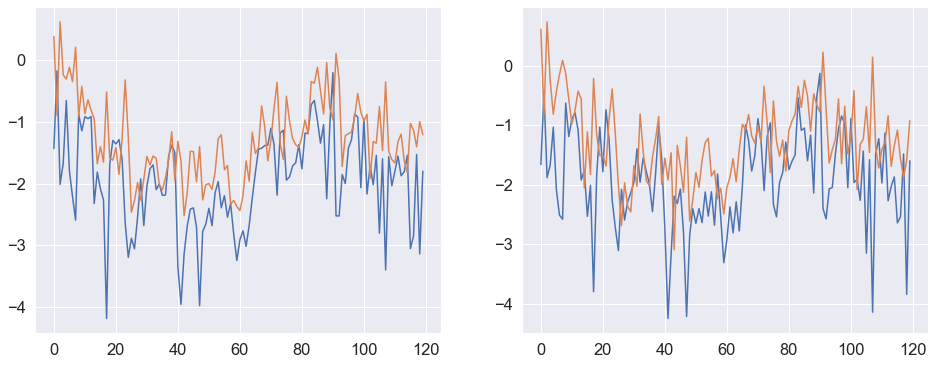

In [6]:
# simulate data and plot
# task dimensions
T = 120
n_dim_state = 2
n_dim_obs = 2
n_dim_control = 2
inp = np.multiply(stats.uniform.rvs(size=[T,n_dim_control]) > 0.8,1)

# initialize model parameters
params = {
    'A': emo.sample_dynamicsmatrix(n_dim_state),  # state transition matrix
    'Q': 0.1 * np.eye(n_dim_obs),  # state noise covariance  wishart.rvs
    'B': np.eye(n_dim_state),  # observation matrix
    'C': stats.multivariate_normal.rvs(size=[n_dim_state, n_dim_control]),  # observation matrix
    'R': 0.1 * np.eye(n_dim_obs),  # observation noise covariance
    'mu_0': np.zeros(n_dim_state),  # initial state mean
    'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
    'h': np.zeros(n_dim_state)
}
opt = {'inputs': True, 'inp': inp}
state, obs = emo.sample_lds(T, params, opt)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.plot(state)
ax2.plot(obs)

In [3]:
# run for different number of observentions, NO inputs, for full and diagonal covariances
opt = {'n_dim_state': 5, 'n_dim_obs': 5, 'n_dim_control': 5, 'inputs': False, \
      'maxiter': 100}
opt['em_vars'] = emo.parameter_short(['A', 'G', 'S'])
maxrun = 1000
number_of_observations = [10,30,50,70,90]

cov_options = ['diagonal', 'full']

dynamicsmatrix_correlation = np.empty([len(number_of_observations),maxrun, len(cov_options)])
distance_dynamics = np.empty([len(number_of_observations),maxrun, len(cov_options)])

for i, j in enumerate(cov_options):

    opt['cov'] = j

    for t in range(len(number_of_observations)):

        T = number_of_observations[t]

        for r in range(maxrun):

            params = emo.initialize_lds(opt)
            state, obs = emo.sample_lds(T, params, opt)

            kf = emo.run_KF(obs, opt)

            dynamicsmatrix_correlation[t,r,i] = np.corrcoef(params['A'].flatten(), kf.transition_matrices.flatten())[0][1]
            distance_dynamics[t,r,i] = emo.calculate_distance(params['A'], kf.transition_matrices)
            
    print(np.mean(dynamicsmatrix_correlation[:,:,i],axis=1),np.mean(distance_dynamics[:,:,i],axis=1))
data = {'dynamics_corr': dynamicsmatrix_correlation, 'dynamics_distance': distance_dynamics}
np.save(filepath + 'results/simulations/simulation_noinputs.npy', data)

[0.29165098 0.59043462 0.71890304 0.79142109 0.84185248] [0.82817446 0.9026904  0.92855795 0.94284928 0.95501657]
[0.29923555 0.52155346 0.62931661 0.6859032  0.71982401] [0.84758353 0.9100406  0.92870578 0.93935426 0.94509059]


diagonal noise covariance


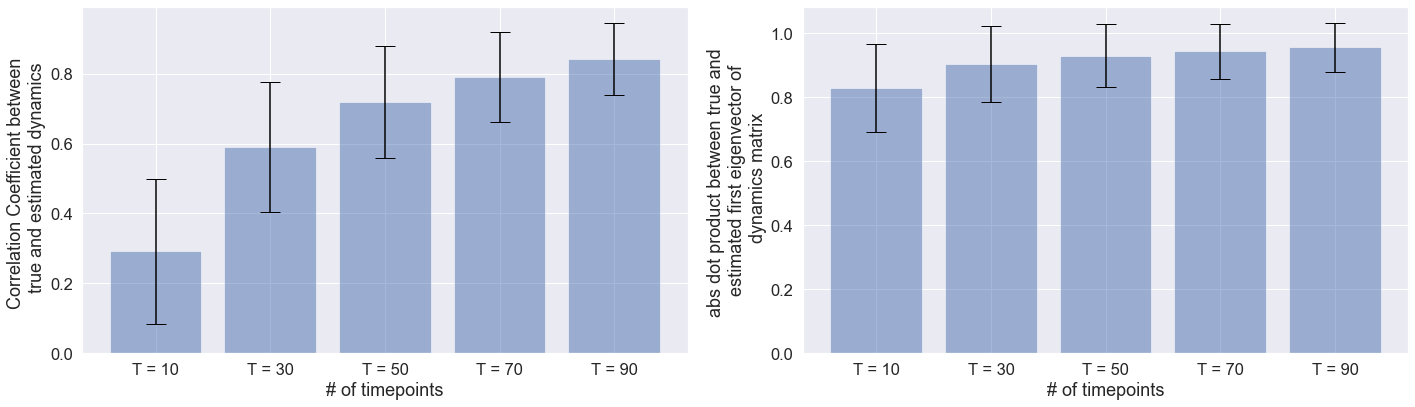

full noise covariance


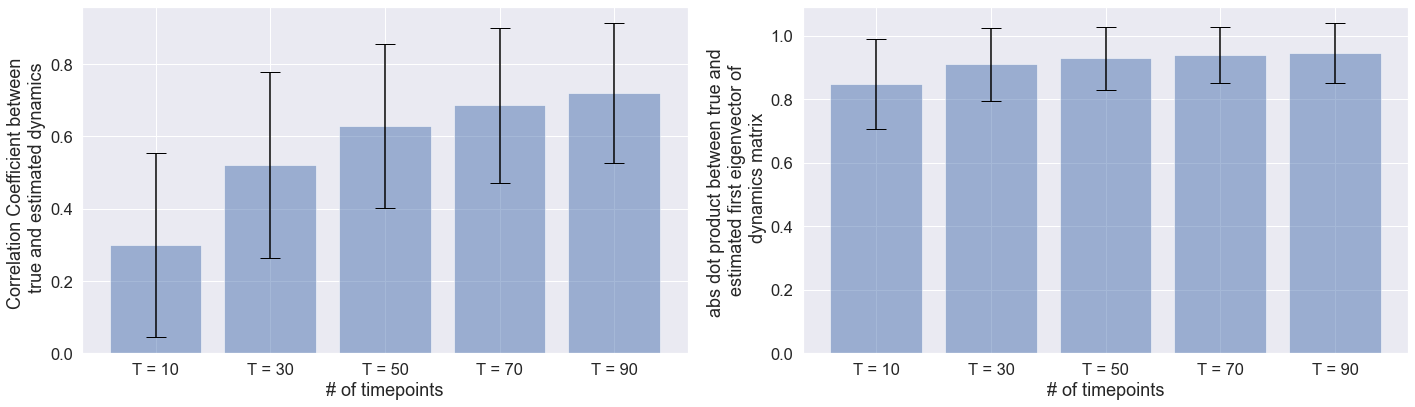

In [7]:
data = np.load(filepath + 'results/simulations/simulation_noinputs.npy',allow_pickle=True).item()
number_of_observations = [10,30,50,70,90]
x_pos = np.arange(len(number_of_observations))
for i in range(2):
    print(['diagonal noise covariance', 'full noise covariance'][i])
    fig,ax = plt.subplots(1,2,figsize=(20, 6))
    m = np.mean(data['dynamics_corr'][:,:,i],axis=1).T
    e = np.std(data['dynamics_corr'][:,:,i],axis=1).T
    ax[0].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[0].set_ylabel('Correlation Coefficient between \n true and estimated dynamics')
    m = np.mean(data['dynamics_distance'][:,:,i],axis=1).T
    e = np.std(data['dynamics_distance'][:,:,i],axis=1).T
    ax[1].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[1].set_ylabel('abs dot product between true and \n estimated first eigenvector of \n dynamics matrix')
    for j in range(2):
        ax[j].set_xticks([])
        ax[j].set_xticks(x_pos)
        ax[j].set_xlabel('# of timepoints') 
        ax[j].set_xticklabels(['T = ' + str(n) for n in number_of_observations])
    plt.tight_layout()
    plt.show()

In [23]:
# run for different number of observentions WITH inputs
opt = {'n_dim_state': 5, 'n_dim_obs': 5, 'n_dim_control': 5, 'inputs': True, 'cov': 'diagonal', \
       'maxiter': 100, 'constraint control': False}
opt['em_vars'] = emo.parameter_short(['A', 'C', 'G', 'S'])
maxrun = 100
number_of_observations = [10,30,50,70,90]
dim_observations = [5]

dynamicsmatrix_correlation = np.empty([len(number_of_observations),maxrun,len(dim_observations)])
distance_dynamics = np.empty([len(number_of_observations),maxrun,len(dim_observations)])
inputmatrix_correlation = np.empty([len(number_of_observations),maxrun,len(dim_observations)])
distance_control = np.empty([len(number_of_observations),maxrun,len(dim_observations)])

for i, j in enumerate(dim_observations):

    for t in range(len(number_of_observations)):

        T = number_of_observations[t]
        
        opt['inp'] = emo.create_inputs(T, opt['n_dim_control'])

        for r in range(maxrun):

            params = emo.initialize_lds(opt)
            state, obs = emo.sample_lds(T, params, opt)

            kf = emo.run_KF(obs, opt)

            dynamicsmatrix_correlation[t,r,i]  = np.corrcoef(params['A'].flatten(), kf.transition_matrices.flatten())[0][1]
            inputmatrix_correlation[t,r,i] = np.corrcoef(params['C'].flatten(), kf.control_matrix.flatten())[0][1]
            distance_dynamics[t,r,i] = emo.calculate_distance(params['A'], kf.transition_matrices)
            true_controlmatrix = control.ctrb(params['A'], params['C'])
            est_controlmatrix = control.ctrb(kf.transition_matrices, kf.control_matrix)
            distance_control[t,r,i]  = emo.calculate_distance(np.dot(true_controlmatrix, true_controlmatrix.T), 
                                                 np.dot(est_controlmatrix, est_controlmatrix.T))
       
    print(np.mean(dynamicsmatrix_correlation[:,:,i],axis=1))
    print(np.mean(distance_dynamics[:,:,i],axis=1))
    print(np.mean(inputmatrix_correlation[:,:,i],axis=1))
    print(np.mean(distance_control[:,:,i],axis=1))

data = {'dynamics_corr': dynamicsmatrix_correlation, 'input_corr': inputmatrix_correlation, \
        'dynamics_distance': distance_dynamics, 'controllability_distance': distance_control}
np.save(filepath + 'results/simulation_inputs.npy', data)

[0.26848651 0.8731375  0.93505702 0.96419249 0.97090587]
[0.78738611 0.9575819  0.97990045 0.98109961 0.98142996]
[0.4553727  0.94040029 0.9735698  0.98237523 0.98717164]
[0.77354866 0.93577812 0.97037917 0.9793416  0.98815988]


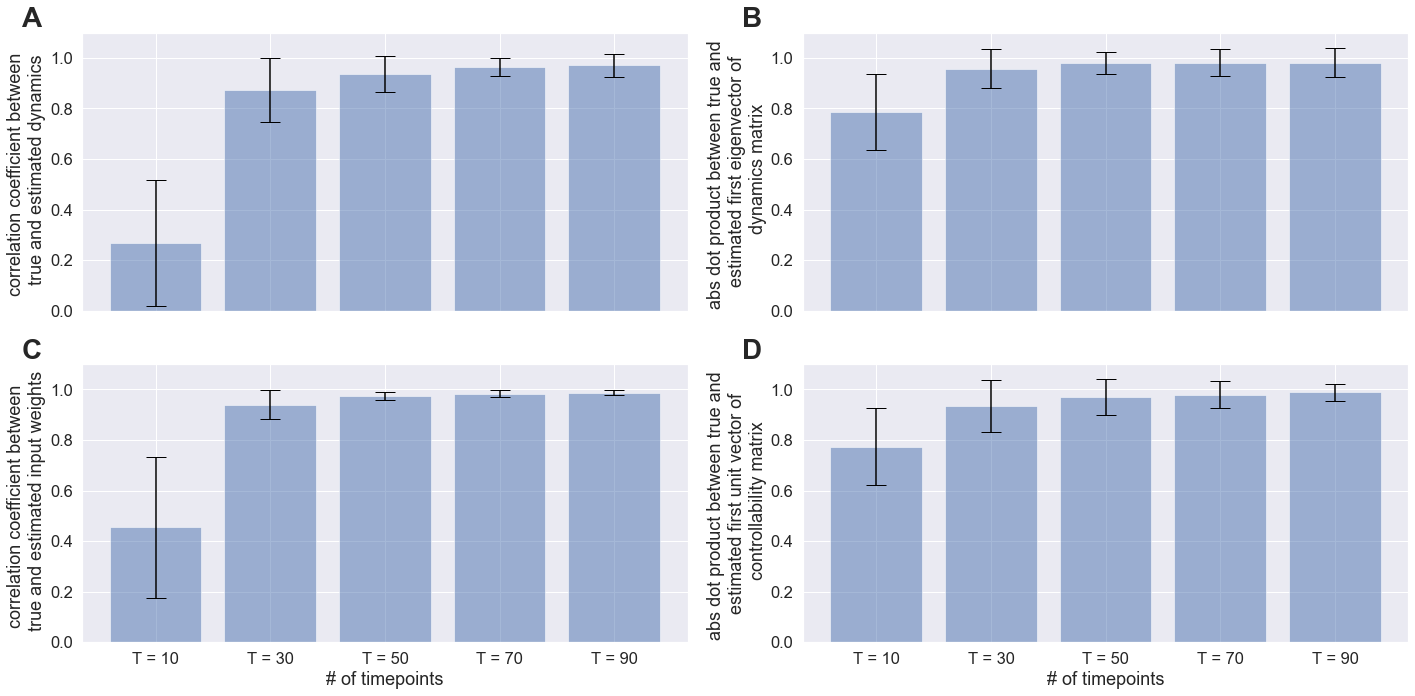

In [8]:
# plot recoverability of parameters based on different number of time-points
data = np.load(filepath + 'results/simulations/simulation_inputs.npy',allow_pickle='TRUE').item()
fig,ax = plt.subplots(2,2,figsize=(20, 10))
number_of_observations = [10,30,50,70,90]
x_pos = np.arange(len(number_of_observations))
for i in range(1):
    m = np.mean(data['dynamics_corr'][:,:,i],axis=1).T
    e = np.std(data['dynamics_corr'][:,:,i],axis=1).T
    ax[0,0].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[0,0].set_ylabel('correlation coefficient between \n true and estimated dynamics')
    m = np.mean(data['dynamics_distance'][:,:,i],axis=1).T
    e = np.std(data['dynamics_distance'][:,:,i],axis=1).T
    ax[0,1].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[0,1].set_ylabel('abs dot product between true and \n estimated first eigenvector of \n dynamics matrix')
    for j in range(2):
        ax[0,j].set_xticklabels([])
        ax[0,j].set_ylim([0, 1.1])
        ax[0,j].text(-0.1, 1.02, ['A', 'B'][j], transform=ax[0,j].transAxes, weight='bold', size=28)
for i in range(1):
    m = np.mean(data['input_corr'][:,:,i],axis=1).T
    e = np.std(data['input_corr'][:,:,i],axis=1).T
    ax[1,0].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[1,0].set_ylabel('correlation coefficient between \n true and estimated input weights')
    m = np.mean(data['controllability_distance'][:,:,i],axis=1).T
    e = np.std(data['controllability_distance'][:,:,i],axis=1).T
    ax[1,1].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[1,1].set_ylabel('abs dot product between true and \n estimated first unit vector of \n controllability matrix')
    for j in range(2):
        ax[1,j].set_xticks([])
        ax[1,j].set_xticks(x_pos)
        ax[1,j].set_xlabel('# of timepoints') 
        ax[1,j].set_xticklabels(['T = ' + str(n) for n in number_of_observations])
        ax[1,j].set_ylim([0, 1.1])
        ax[1,j].text(-0.1, 1.02, ['C', 'D'][j], transform=ax[1,j].transAxes, weight='bold', size=28)
plt.tight_layout()
plt.savefig(filepath + 'results/figures/simulation_inputs.svg')